In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings 
warnings.simplefilter('ignore')

In [2]:
df = pd.read_csv(r"E:\Data Science by SRK\Machine_learning\Classification\penguin_data\cleaned_dataset_penguin.csv")

In [3]:
df

,species,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,island_Dream,island_Torgersen,gender_MALE
0,0,39.1,18.7,181.0,3750.0,False,True,True
1,0,39.5,17.4,186.0,3800.0,False,True,False
2,0,40.3,18.0,195.0,3250.0,False,True,False
3,0,36.7,19.3,193.0,3450.0,False,True,False
4,0,39.3,20.6,190.0,3650.0,False,True,True
...,...,...,...,...,...,...,...,...
329,2,47.2,13.7,214.0,4925.0,False,False,False
330,2,46.8,14.3,215.0,4850.0,False,False,False
331,2,50.4,15.7,222.0,5750.0,False,False,True
332,2,45.2,14.8,212.0,5200.0,False,False,False


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334 entries, 0 to 333
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            334 non-null    int64  
 1   culmen_length_mm   334 non-null    float64
 2   culmen_depth_mm    334 non-null    float64
 3   flipper_length_mm  334 non-null    float64
 4   body_mass_g        334 non-null    float64
 5   island_Dream       334 non-null    bool   
 6   island_Torgersen   334 non-null    bool   
 7   gender_MALE        334 non-null    bool   
dtypes: bool(3), float64(4), int64(1)
memory usage: 14.2 KB


In [5]:
df.isnull().sum()

species              0
culmen_length_mm     0
culmen_depth_mm      0
flipper_length_mm    0
body_mass_g          0
island_Dream         0
island_Torgersen     0
gender_MALE          0
dtype: int64

# X and y

In [6]:
X = df.drop(columns = ['species'])
y = df['species']

# Train_test_split

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state= True)

# XGBoost

**Applying Hyperparameter tuning for identifying best parameters for xgboost**

In [8]:
# !pip install xgboost


In [9]:
from sklearn.model_selection import GridSearchCV

# modelling

from xgboost import XGBClassifier

estimator_xgb = XGBClassifier()

# parameters grid
param_grid_xgb = {"n_estimators" : [1,5,10,20],
                  'max_depth': [3,4,5],
                'gamma' : [0.1, 0.15, 0.3, 0.5, 1]}

# grid search
grid_xgb = GridSearchCV(estimator_xgb, param_grid_xgb, cv = 5, scoring = 'accuracy')
grid_xgb.fit(X_train, y_train)

# best parameters for GradientBoostingClassifier model
grid_xgb.best_params_

{'gamma': 0.1, 'max_depth': 3, 'n_estimators': 20}

# XGB Model imortant features

In [12]:
feats_xgb = pd.DataFrame(data=grid_xgb.best_estimator_.feature_importances_,
                        index = X.columns,
                        columns=['Importance'])
imp_features_list_xgb = feats_xgb[feats_xgb['Importance'] > 0].index.to_list()
imp_features_list_xgb

['culmen_length_mm',
 'culmen_depth_mm',
 'flipper_length_mm',
 'body_mass_g',
 'island_Dream',
 'island_Torgersen',
 'gender_MALE']

# Xtreme GradientBoost with important features and best hyperparameters

In [13]:
X_imp_xgb = X[imp_features_list_xgb]

X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_imp_xgb, y, test_size = 0.2,
                                                                   random_state = True)

# modelling
from xgboost import XGBClassifier
xgb = XGBClassifier(gamma = 0.1, max_depth = 3, n_estimators = 20)
xgb.fit(X_train_xgb, y_train_xgb)

#Evaluation train data
from sklearn.metrics import accuracy_score
ypred_train = xgb.predict(X_train_xgb)
print("Train accuracy : ", accuracy_score(y_train_xgb, ypred_train))

# Cross_val_score
from sklearn.model_selection import cross_val_score
print("cross_val_score : ", cross_val_score(xgb, X_train_xgb, y_train_xgb, cv = 5).mean())

#Evaluation test data
ypred_test = xgb.predict(X_test_xgb)
print("Test accuracy : ", accuracy_score(y_test_xgb, ypred_test))


Train accuracy :  1.0
cross_val_score :  0.9850454227812717
Test accuracy :  1.0


In [14]:
%%timeit
xgb.fit(X_train_xgb, y_train_xgb)


36 ms ± 2.23 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Final model

In [15]:
xgb = XGBClassifier(gamma = 0.1, max_depth = 3, n_estimators = 20)


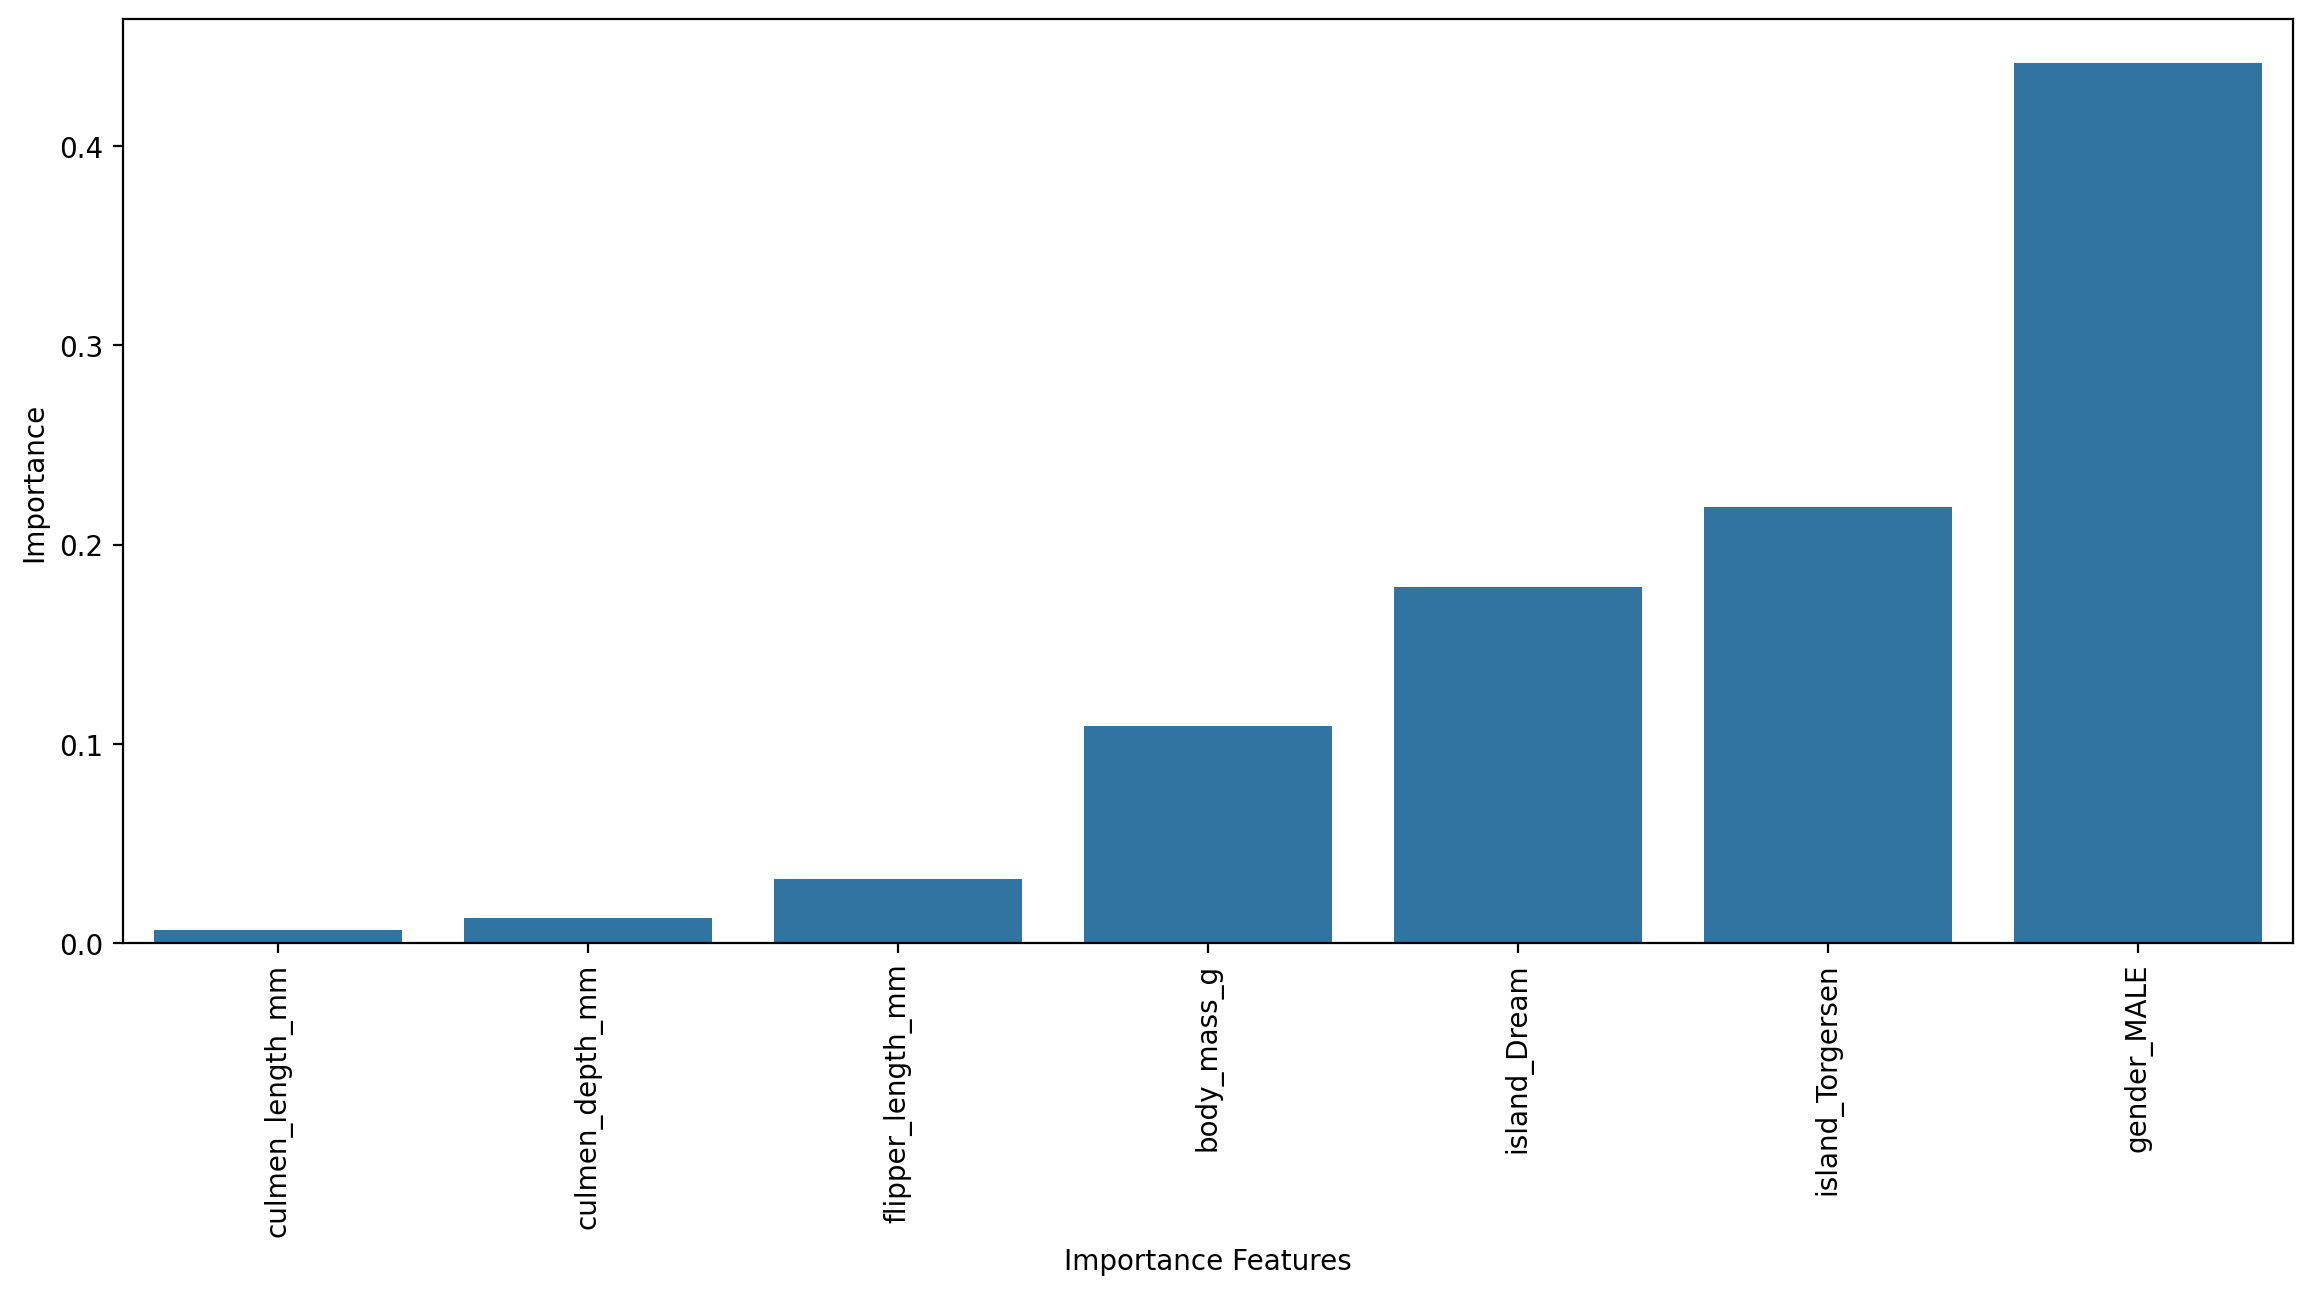

In [16]:
plt.figure(figsize = (14,6), dpi = 200)

sns.barplot(data = feats_xgb[feats_xgb['Importance'] > 0].sort_values('Importance'),
           x = feats_xgb[feats_xgb['Importance'] > 0].index,
           y = 'Importance')
plt.xticks(rotation = 90)
plt.xlabel('Importance Features')
plt.show()

In [17]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test_xgb, ypred_test)

array([[28,  0,  0],
       [ 0, 17,  0],
       [ 0,  0, 22]], dtype=int64)

In [18]:
from sklearn.metrics import classification_report
print(classification_report(y_test_xgb, ypred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        28
           1       1.00      1.00      1.00        17
           2       1.00      1.00      1.00        22

    accuracy                           1.00        67
   macro avg       1.00      1.00      1.00        67
weighted avg       1.00      1.00      1.00        67

